In [27]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [28]:
# --- 2. Data Loading ---
df = pd.read_csv("Data/engines2_data_cleaned_no_outliers.csv")
df.info()
df['eng_number'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84169 entries, 0 to 84168
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   eposition             84169 non-null  int64  
 1   flight_phase          84169 non-null  object 
 2   eng_install_date      84169 non-null  object 
 3   cycles                84169 non-null  float64
 4   egt_probe_average     84169 non-null  float64
 5   fuel_flw              84169 non-null  float64
 6   corrected_fan_spd     56892 non-null  float64
 7   core_spd              84169 non-null  float64
 8   zpn12p                84169 non-null  float64
 9   vib_n1_#1_bearing     84169 non-null  float64
 10  vib_n2_#1_bearing     84169 non-null  float64
 11  vib_n2_turbine_frame  84169 non-null  float64
 12  eng_type              84169 non-null  int64  
 13  eng_number            84169 non-null  int64  
 14  flight_datetime_c     84169 non-null  object 
 15  date               

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [29]:
# --- 3. Feature Engineering ---
df['flight_datetime_c'] = pd.to_datetime(df['flight_datetime_c'])
df['hour'] = df['flight_datetime_c'].dt.hour
df['dayofweek'] = df['flight_datetime_c'].dt.dayofweek
df['month'] = df['flight_datetime_c'].dt.month
df['day'] = df['flight_datetime_c'].dt.day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df.drop(columns=['hour', 'month', 'dayofweek', 'day'], inplace=True)
df = pd.get_dummies(df, columns=["flight_phase"])

In [30]:
# --- 4. Feature Selection ---
sensor_cols = [
    'flight_cycle','egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p',
    'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame',
    'month_sin', 'month_cos', 'dayofweek_sin','dayofweek_cos'
] + [col for col in df.columns if col.startswith("flight_phase_")]

In [43]:
# --- 5. Data Splitting ---
def split_by_group_with_test_engine(df, test_engine, group_col='eng_number', train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    """
    Split DataFrame into train, val, and test sets by group, with a specific engine as test set.
    """
    from sklearn.model_selection import GroupShuffleSplit
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1"
    test_mask = df[group_col] == test_engine
    df_test = df[test_mask].copy()
    df_rest = df[~test_mask].copy()
    # Adjust train/val split since test is fixed
    total = len(df_rest[group_col].unique())
    val_ratio = val_size / (train_size + val_size)
    gss = GroupShuffleSplit(n_splits=1, test_size=val_ratio, random_state=random_state)
    train_idx, val_idx = next(gss.split(df_rest, groups=df_rest[group_col]))
    df_train = df_rest.iloc[train_idx].copy()
    df_val = df_rest.iloc[val_idx].copy()
    return df_train, df_val, df_test

# Use the improved function for splitting with test engine 3
df_train, df_val, df_test = split_by_group_with_test_engine(df, test_engine=3, group_col='eng_number', train_size=0.8, val_size=0.1, test_size=0.1, random_state=42)

In [44]:
# print unique eng_number in each set
print("Train set unique eng_number:", df_train['eng_number'].unique())
print("Validation set unique eng_number:", df_val['eng_number'].unique())
print("Test set unique eng_number:", df_test['eng_number'].unique())


Train set unique eng_number: [2 4 5 6 7]
Validation set unique eng_number: [1]
Test set unique eng_number: [3]


In [45]:
# --- 6. Scaling ---
scaler = MinMaxScaler()
df_train[sensor_cols] = scaler.fit_transform(df_train[sensor_cols])
df_val[sensor_cols] = scaler.transform(df_val[sensor_cols])
df_test[sensor_cols] = scaler.transform(df_test[sensor_cols])
rul_scaler = MinMaxScaler()
df_train['RUL'] = rul_scaler.fit_transform(df_train[['RUL']])
df_val['RUL'] = rul_scaler.transform(df_val[['RUL']])
df_test['RUL'] = rul_scaler.transform(df_test[['RUL']])

In [46]:
# --- 7. LSTM Windowing Function ---
def create_lstm_windows(data, window_size=8, stride=1, add_noise=False, noise_std=0.01):
    X, y = [], []
    for engine_id in data['eng_number'].unique():
        engine_df = data[data['eng_number'] == engine_id].reset_index(drop=True)
        for i in range(0, len(engine_df) - window_size, stride):
            window = engine_df.loc[i:i+window_size-1, sensor_cols].values.astype(np.float32)
            if add_noise:
                noise = np.random.normal(loc=0.0, scale=noise_std, size=window.shape)
                window += noise
            label = engine_df.loc[i + window_size - 1, 'RUL']
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

In [47]:
# --- 8. Prepare Data for LSTM ---
X_train, y_train = create_lstm_windows(df_train, window_size=10, stride=1)
X_val, y_val = create_lstm_windows(df_val, window_size=10, stride=1)
X_test, y_test = create_lstm_windows(df_test, window_size=10, stride=1)

63/63 [==============================] - 6s 13ms/step - loss: 0.2572


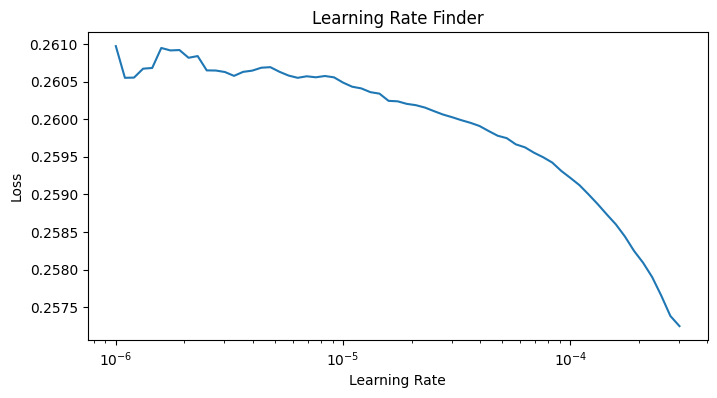

In [48]:
# --- 9. Learning Rate Finder ---
class LRFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1, steps=100):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        self.best_loss = float('inf')
    def on_train_batch_end(self, batch, logs=None):
        lr = self.min_lr * (self.max_lr / self.min_lr) ** (batch / self.steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.lrs.append(lr)
        loss = logs.get('loss')
        self.losses.append(loss)
        if loss < self.best_loss:
            self.best_loss = loss
        if batch >= self.steps:
            self.model.stop_training = True

X_lr, y_lr = X_train[:2000], y_train[:2000]
model_lr = Sequential()
model_lr.add(LSTM(64, return_sequences=True, input_shape=(X_lr.shape[1], X_lr.shape[2]), kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_lr.add(Dropout(0.2))
model_lr.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_lr.add(Dropout(0.2))
model_lr.add(LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_lr.add(Dropout(0.2))
model_lr.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_lr.add(Dense(1))
model_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=Huber(delta=0.1))
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2, steps=100)
model_lr.fit(X_lr, y_lr, batch_size=32, epochs=1, callbacks=[lr_finder], verbose=1)
def plot_lr_finder(lrs, losses):
    plt.figure(figsize=(8, 4))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.show()
plot_lr_finder(lr_finder.lrs, lr_finder.losses)
# best_lr = ... (set after inspecting the plot)

In [49]:
# --- 10. Build and Train LSTM Model ---
WINDOW_SIZE = 20  # Define window size as a constant

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Replace with best_lr if found
    decay_steps=10_000,
    decay_rate=0.96,
    staircase=True
)

# First create the windowed data
X_train, y_train = create_lstm_windows(df_train, window_size=WINDOW_SIZE, stride=2)
X_val, y_val = create_lstm_windows(df_val, window_size=WINDOW_SIZE, stride=2)
X_test, y_test = create_lstm_windows(df_test, window_size=WINDOW_SIZE, stride=2)

# Then create the model with matching input shape
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, len(sensor_cols)), kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
             loss=Huber(delta=0.1), 
             metrics=[MeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint("best_lstm2_model", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=(X_val, y_val), 
                   callbacks=[early_stop, checkpoint_cb], 
                   verbose=1)

best_model = load_model("best_lstm2_model")

Epoch 1/50
920/920 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.0123
Epoch 1: val_loss improved from inf to 0.00238, saving model to best_lstm2_model

Epoch 1: val_loss improved from inf to 0.00238, saving model to best_lstm2_model

Epoch 1: val_loss improved from inf to 0.00238, saving model to best_lstm2_model
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets


INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 32s 29ms/step - loss: 0.0205 - mean_squared_error: 0.0123 - val_loss: 0.0024 - val_mean_squared_error: 0.0021
Epoch 2/50
Epoch 2/50
Epoch 2/50
920/920 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0044
Epoch 2: val_loss improved from 0.00238 to 0.00194, saving model to best_lstm2_model

Epoch 2: val_loss improved from 0.00238 to 0.00194, saving model to best_lstm2_model

Epoch 2: val_loss improved from 0.00238 to 0.00194, saving model to best_lstm2_model
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets


INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 27s 30ms/step - loss: 0.0030 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0025
Epoch 3/50
Epoch 3/50
Epoch 3/50
918/920 [============================>.] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0040
Epoch 3: val_loss did not improve from 0.00194
920/920 [==============================] - 23s 25ms/step - loss: 0.0025 - mean_squared_error: 0.0040 - val_loss: 0.0026 - val_mean_squared_error: 0.0042
Epoch 4/50

Epoch 3: val_loss did not improve from 0.00194
920/920 [==============================] - 23s 25ms/step - loss: 0.0025 - mean_squared_error: 0.0040 - val_loss: 0.0026 - val_mean_squared_error: 0.0042
Epoch 4/50

Epoch 3: val_loss did not improve from 0.00194
920/920 [==============================] - 23s 25ms/step - loss: 0.0025 - mean_squared_error: 0.0040 - val_loss: 0.0026 - val_mean_squared_error: 0.0042
Epoch 4/50
920/920 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_err

INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 27s 29ms/step - loss: 0.0022 - mean_squared_error: 0.0035 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/50
919/920 [============================>.] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0030
Epoch 5: val_loss improved from 0.00102 to 0.00101, saving model to best_lstm2_model

Epoch 5: val_loss improved from 0.00102 to 0.00101, saving model to best_lstm2_model

Epoch 5: val_loss improved from 0.00102 to 0.00101, saving model to best_lstm2_model
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets


INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 28s 30ms/step - loss: 0.0019 - mean_squared_error: 0.0030 - val_loss: 0.0010 - val_mean_squared_error: 0.0011
Epoch 6/50
Epoch 6/50
Epoch 6/50
920/920 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0028
Epoch 6: val_loss improved from 0.00101 to 0.00091, saving model to best_lstm2_model

Epoch 6: val_loss improved from 0.00101 to 0.00091, saving model to best_lstm2_model

Epoch 6: val_loss improved from 0.00101 to 0.00091, saving model to best_lstm2_model
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets


INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 27s 29ms/step - loss: 0.0018 - mean_squared_error: 0.0028 - val_loss: 9.0877e-04 - val_mean_squared_error: 9.0975e-04
Epoch 7/50
Epoch 7/50
Epoch 7/50
919/920 [============================>.] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0025
Epoch 7: val_loss improved from 0.00091 to 0.00087, saving model to best_lstm2_model

Epoch 7: val_loss improved from 0.00091 to 0.00087, saving model to best_lstm2_model

Epoch 7: val_loss improved from 0.00091 to 0.00087, saving model to best_lstm2_model
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets
INFO:tensorflow:Assets written to: best_lstm2_model\assets


INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 26s 28ms/step - loss: 0.0016 - mean_squared_error: 0.0025 - val_loss: 8.6701e-04 - val_mean_squared_error: 9.0261e-04
Epoch 8/50
Epoch 8/50
Epoch 8/50
920/920 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0024
Epoch 8: val_loss did not improve from 0.00087
920/920 [==============================] - 21s 23ms/step - loss: 0.0016 - mean_squared_error: 0.0024 - val_loss: 9.8023e-04 - val_mean_squared_error: 0.0012
Epoch 9/50

Epoch 8: val_loss did not improve from 0.00087
920/920 [==============================] - 21s 23ms/step - loss: 0.0016 - mean_squared_error: 0.0024 - val_loss: 9.8023e-04 - val_mean_squared_error: 0.0012
Epoch 9/50

Epoch 8: val_loss did not improve from 0.00087
920/920 [==============================] - 21s 23ms/step - loss: 0.0016 - mean_squared_error: 0.0024 - val_loss: 9.8023e-04 - val_mean_squared_error: 0.0012
Epoch 9/50
920/920 [==============================] - ETA: 0s - loss: 0.001

INFO:tensorflow:Assets written to: best_lstm2_model\assets


920/920 [==============================] - 27s 29ms/step - loss: 0.0013 - mean_squared_error: 0.0019 - val_loss: 8.6531e-04 - val_mean_squared_error: 0.0011
Epoch 15/50
919/920 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0018
Epoch 15: val_loss did not improve from 0.00087
920/920 [==============================] - 22s 24ms/step - loss: 0.0012 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0021
Epoch 16/50

Epoch 15: val_loss did not improve from 0.00087
920/920 [==============================] - 22s 24ms/step - loss: 0.0012 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0021
Epoch 16/50

Epoch 15: val_loss did not improve from 0.00087
920/920 [==============================] - 22s 24ms/step - loss: 0.0012 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0021
Epoch 16/50
920/920 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0018


In [50]:
# --- 11. Validation and Test Evaluation ---
y_pred_val = best_model.predict(X_val).flatten()
y_pred_val = rul_scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
y_val = rul_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f"\n✅ Validation MAE: {mae_val:.2f}")
print(f"✅ Validation R² Score: {r2_val:.3f}")
y_pred_test = best_model.predict(X_test).flatten()
y_pred_test = rul_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"\n✅ Test MAE: {mae_test:.2f}")
print(f"✅ Test R² Score: {r2_test:.3f}")

200/200 [==============================] - 2s 5ms/step

✅ Validation MAE: 129.54
✅ Validation MAE: 129.54
✅ Validation MAE: 129.54
✅ Validation R² Score: 0.985
  1/194 [..............................] - ETA: 4s
✅ Validation R² Score: 0.985
  1/194 [..............................] - ETA: 4s
✅ Validation R² Score: 0.985
194/194 [==============================] - 1s 6ms/step

✅ Test MAE: 289.32
✅ Test R² Score: 0.942

✅ Test MAE: 289.32
✅ Test R² Score: 0.942

✅ Test MAE: 289.32
✅ Test R² Score: 0.942


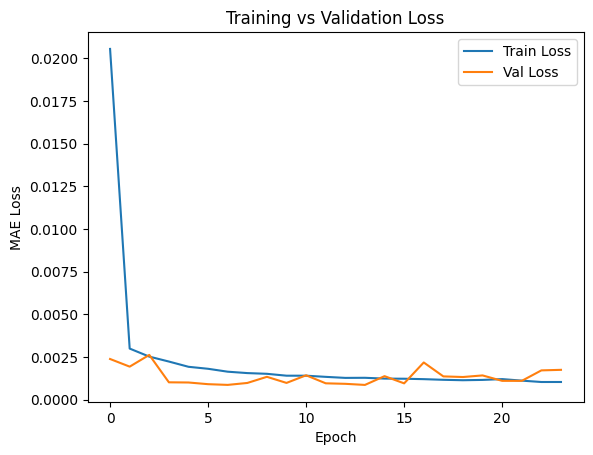

In [51]:
# --- 12. Plot Training History ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

In [60]:
# retrain the model using all the available data
# scale df
df_all = df.copy()
# replicate all the stepsabove and retrain the model on the complete data set
scaler = MinMaxScaler()
df_all[sensor_cols] = scaler.fit_transform(df_all[sensor_cols])
rul_scaler = MinMaxScaler()
df_all['RUL'] = rul_scaler.fit_transform(df_all[['RUL']])

X_all, y_all = create_lstm_windows(df_all, window_size=WINDOW_SIZE, stride=2)
model_all = Sequential()
model_all.add(LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, len(sensor_cols)), kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_all.add(Dropout(0.2))
model_all.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_all.add(Dropout(0.2))
model_all.add(LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1))
model_all.add(Dropout(0.2))
model_all.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_all.add(Dense(1))
model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
             loss=Huber(delta=0.1), 
             metrics=[MeanSquaredError()])
early_stop_all = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_cb_all = ModelCheckpoint("best_lstm2_model_all", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
history_all = model_all.fit(X_all, y_all, 
                   epochs=50, 
                   batch_size=32, 
                   validation_split=0.1, 
                   callbacks=[early_stop_all, checkpoint_cb_all], 
                   verbose=1)
best_model_all = load_model("best_lstm2_model_all")



Epoch 1/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0175 - mean_squared_error: 0.0079
Epoch 1: val_loss improved from inf to 0.01225, saving model to best_lstm2_model_all

Epoch 1: val_loss improved from inf to 0.01225, saving model to best_lstm2_model_all

Epoch 1: val_loss improved from inf to 0.01225, saving model to best_lstm2_model_all
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets


INFO:tensorflow:Assets written to: best_lstm2_model_all\assets


1182/1182 [==============================] - 43s 31ms/step - loss: 0.0175 - mean_squared_error: 0.0079 - val_loss: 0.0123 - val_mean_squared_error: 0.0270
Epoch 2/50
Epoch 2/50
Epoch 2/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0030
Epoch 2: val_loss improved from 0.01225 to 0.00761, saving model to best_lstm2_model_all

Epoch 2: val_loss improved from 0.01225 to 0.00761, saving model to best_lstm2_model_all

Epoch 2: val_loss improved from 0.01225 to 0.00761, saving model to best_lstm2_model_all
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets
INFO:tensorflow:Assets written to: best_lstm2_model_all\assets


INFO:tensorflow:Assets written to: best_lstm2_model_all\assets


1182/1182 [==============================] - 38s 33ms/step - loss: 0.0022 - mean_squared_error: 0.0030 - val_loss: 0.0076 - val_mean_squared_error: 0.0157
Epoch 3/50
Epoch 3/50
Epoch 3/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0028
Epoch 3: val_loss did not improve from 0.00761
1182/1182 [==============================] - 33s 28ms/step - loss: 0.0019 - mean_squared_error: 0.0028 - val_loss: 0.0144 - val_mean_squared_error: 0.0369
Epoch 4/50

Epoch 3: val_loss did not improve from 0.00761
1182/1182 [==============================] - 33s 28ms/step - loss: 0.0019 - mean_squared_error: 0.0028 - val_loss: 0.0144 - val_mean_squared_error: 0.0369
Epoch 4/50

Epoch 3: val_loss did not improve from 0.00761
1182/1182 [==============================] - 33s 28ms/step - loss: 0.0019 - mean_squared_error: 0.0028 - val_loss: 0.0144 - val_mean_squared_error: 0.0369
Epoch 4/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0017 - mean

INFO:tensorflow:Assets written to: best_lstm2_model_all\assets


1182/1182 [==============================] - 38s 32ms/step - loss: 0.0013 - mean_squared_error: 0.0020 - val_loss: 0.0039 - val_mean_squared_error: 0.0073
Epoch 13/50
Epoch 13/50
Epoch 13/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0020
Epoch 13: val_loss did not improve from 0.00390
1182/1182 [==============================] - 34s 29ms/step - loss: 0.0013 - mean_squared_error: 0.0020 - val_loss: 0.0106 - val_mean_squared_error: 0.0244
Epoch 14/50

Epoch 13: val_loss did not improve from 0.00390
1182/1182 [==============================] - 34s 29ms/step - loss: 0.0013 - mean_squared_error: 0.0020 - val_loss: 0.0106 - val_mean_squared_error: 0.0244
Epoch 14/50

Epoch 13: val_loss did not improve from 0.00390
1182/1182 [==============================] - 34s 29ms/step - loss: 0.0013 - mean_squared_error: 0.0020 - val_loss: 0.0106 - val_mean_squared_error: 0.0244
Epoch 14/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.00

In [55]:
df_all.head()


,eposition,eng_install_date,cycles,egt_probe_average,fuel_flw,corrected_fan_spd,core_spd,zpn12p,vib_n1_#1_bearing,vib_n2_#1_bearing,...,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,flight_phase_CLIMB,flight_phase_CRUISE,flight_phase_TAKEOFF
0,2,19-01-20 22:00,37.0,0.588976,0.090173,80.0524,0.670894,0.657788,0.018964,0.162791,...,-0.258819,0.0,0.356896,0.933013,0.75,-0.394356,0.918958,0.0,0.0,1.0
1,2,19-01-20 22:00,38.0,0.709101,0.939812,NaN,0.791667,0.943544,0.188791,0.139535,...,-0.258819,0.0,0.356896,0.933013,0.75,-0.394356,0.918958,1.0,0.0,0.0
2,2,19-01-20 22:00,38.0,0.428310,0.288685,NaN,0.652778,0.766358,0.547127,0.279070,...,-0.500000,0.0,0.356896,0.933013,0.75,-0.394356,0.918958,0.0,1.0,0.0
3,2,19-01-20 22:00,39.0,0.762827,0.909389,NaN,0.853865,0.958888,0.150863,0.093023,...,-0.965926,0.0,0.356896,0.933013,0.75,-0.394356,0.918958,1.0,0.0,0.0
4,2,19-01-20 22:00,38.0,0.777367,0.125629,82.7977,0.840580,0.795310,0.037645,0.046512,...,-0.965926,0.0,0.356896,0.933013,0.75,-0.394356,0.918958,0.0,0.0,1.0
